# Librerias Necesarias

In [0]:
import numpy as np
import pandas as pd
from pandas_datareader import data
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.tsa.stattools as ts
import warnings
warnings.filterwarnings("ignore")

# Funciones que leen los datos

In [0]:
def odata(ticker, start, end):
    return data.DataReader(ticker, 'yahoo', start, end)

def oget(tickers, start, end):
    Alldata = []
    for t in tickers:
        rdata = odata(t,start,end)
        Alldata.append(rdata)
    return pd.concat(Alldata, keys=tickers, names=['Ticker','Date'])

#Función para encontrar pares

Dada una lista de activos ($\texttt{securities}$ ) y una ventana de tiempo ($\texttt{window}$) se hace el test de cointegración para todas los pares posibles y aquellos pares que pasen el test serán almacenados en una lista, de igual forma la función exporta la matriz de scores y la matriz de p-valores.

In [0]:
def find_cointegrated_pairs(securities,window):
    n = len(securities.columns)
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = securities.columns
    pairs = []
    pvof = []
    for i in range(n):
        for j in range(n):
          if i != j:
              S1 = securities[keys[i]][-window:]
              S2 = securities[keys[j]][-window:]
              result = ts.coint(S1, S2)
              score = result[0]
              pvalue = result[1]
              score_matrix[i, j] = score
              pvalue_matrix[i, j] = pvalue
              if pvalue < .1 and not([keys[i],keys[j]][::-1] in pairs):
                pairs.append([keys[i], keys[j]])
    return score_matrix, pvalue_matrix, pairs

# Función para Generar Trayectorias de Precios

Esta función genera $n$ trayectorias ($\texttt{I}$) con un largo de $\texttt{W}$ periodos, es necesario especificar el precio inicial, la tasa de retorno y desviación estándar del activo a simular precios.

In [0]:
def gen_paths(S0, r, sigma, W, I):
    dt = float(1) / W
    paths = np.zeros((W + 1, I), np.float64)
    paths[0] = S0
    for t in range(1, W + 1):
        rand = np.random.standard_normal(I)
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * rand)
    return paths

# Función para Test de Estabilidad del P-Valor

Esta función busca realizar un test de estabilidad del p-valor visualizando la distribución de éste. Para ello se simulan las trayectorias de los precios para crear distintos escenarios del p-valor del par. La característica deseada es tener una distribución lo más parecida a una exponencial.

In [0]:
def p_value_stability(pair_tickers, last_date, numb_paths, window, w_p_value):
  T = int(window / 3)
  date_t = last_date
  date_0 = date_t - timedelta(days=window)
  tck_data = odata(pair_tickers, date_0,date_t)
  clspx = tck_data[['Adj Close']]
  keys = clspx.columns
  r_a = np.log(clspx[keys[0]]).mean() / window
  r_b = np.log(clspx[keys[1]]).mean() / window
  sigma_a = np.log(clspx[keys[0]]).std()
  sigma_b = np.log(clspx[keys[1]]).std()
  paths_a = pd.DataFrame(gen_paths(clspx[keys[0]][0], r_a, sigma_a, T ,numb_paths))
  paths_b = pd.DataFrame(gen_paths(clspx[keys[1]][0], r_b, sigma_b, T ,numb_paths))
  pvalue_l = []
  for p in paths_a.columns:
    for q in paths_b.columns:
      S1 = pd.Series(np.concatenate((clspx[keys[0]].values, paths_a[p].values)))[-w_p_value:]
      S2 = pd.Series(np.concatenate((clspx[keys[1]].values, paths_a[q].values)))[-w_p_value:]
      result = ts.coint(S1, S2)
      pvalue_l.append(result[1])
  '''
  sns.distplot(pd.DataFrame(pvalue_l), hist=True, kde=True, 
              bins=int(50), color = 'darkblue', 
              hist_kws={'edgecolor':'black'},
              kde_kws={'linewidth': 2})'''
  #sns.set();
  plt.figure(figsize=(12,4))
  sns.distplot(pvalue_l, bins = numb_paths*10)
  plt.title(keys[0][1] + ' / ' + keys[1][1] + ' || ' + 'Window = '+str(w_p_value))
  plt.show();
  #print(pd.DataFrame(pvalue_l).mean()[0], pd.DataFrame(pvalue_l).max()[0])


#Función de Validación de Cointegración con Distintos Plazos

Se realiza el test de cointegración para los pares con distintas ventanas de tiempo con el fin de validar la existencia de una cointegración estable a lo largo del tiempo.

In [0]:
def pair_test(pair_tickers, last_date):
  date_t = last_date
  date_0 = date_t - timedelta(days=252*3)
  tck_data = odata(pair_tickers, date_0,date_t)
  clspx = tck_data[['Adj Close']]
  keys = clspx.columns
  p_v = []
  for tau in [126,252,126+252,252*2]:
    S1 = clspx[keys[0]][-tau:]
    S2 = clspx[keys[1]][-tau:]
    p_v.append((tau,ts.coint(S1, S2)[1]))
  return pd.DataFrame(p_v, columns = ['Window (d)',keys[0][1]+' / '+keys[1][1]])


#Función de Evaluación de Operabilidad de Pares

Es una función que incluye el test de estabilidad del p-valor (es opcional, depende si el último parámetro es igual a "Y", en otro caso no incuira el test) y un gráfico de como se habría operado durante una ventana de tiempo, adjuntando el comportamiento del z-score del ratio del par.

In [0]:
def pair_evaluation(pair_tickers, last_date, trigger, w_t, w_T, numb_paths ,window, w_p_value, stability):
  date_t = last_date
  date_0 = date_t - timedelta(days=window)
  tck_data = oget(pair_tickers, date_0,date_t)
  clspx = tck_data[['Adj Close']].reset_index()
  px = clspx.pivot('Date', 'Ticker','Adj Close')
  keys = px.columns
  a_b = pair_test(pair_tickers, last_date)
  b_a = pair_test(pair_tickers[::-1], last_date)
  display(pd.merge(a_b,b_a,'inner','Window (d)').set_index('Window (d)'))
  if stability == 'Y':
    p_value_stability(pair_tickers, last_date, numb_paths, window, w_p_value)

  if (a_b.iloc[:,1] < .1).astype(int).sum() >= (b_a.iloc[:,1] < .1).astype(int).sum():
    px['ratio'] = px[keys[0]] / px[keys[1]]
    name = a_b.columns[1]
  else:
    px['ratio'] = px[keys[1]] / px[keys[0]]
    name = b_a.columns[1]

  px['ma_t'] = px['ratio'].rolling(window=w_t,center=False).mean()
  px['ma_T'] = px['ratio'].rolling(window=w_T,center=False).mean()
  px['mstd_T'] = px['ratio'].rolling(window=w_T,center=False).std()
  px['z_score'] = (px['ma_t'] - px['ma_T']) / px['mstd_T']
  buy = px['z_score'].copy()
  sell = px['z_score'].copy()
  buy[px['z_score']>-trigger] = np.nan
  sell[px['z_score']<trigger] = np.nan
  S1 = px[name.split(' / ')[0]]
  S2 = px[name.split(' / ')[1]]
  buyR = 0*S1.copy()
  sellR = 0*S1.copy()
  buyR[buy.notnull()] = S1[buy.notnull()]
  sellR[buy.notnull()] = S2[buy.notnull()]
  buyR[sell.notnull()] = S2[sell.notnull()]
  sellR[sell.notnull()] = S1[sell.notnull()]
  buyR = buyR.replace([0],[np.nan])
  sellR = sellR.replace([0],[np.nan])
  plt.figure(figsize=(12,6))
  S1.plot(color = 'c')
  S2.plot(color = 'grey')
  sellR.plot(color='r', linestyle='None', marker='v')
  buyR.plot(color='g', linestyle='None', marker='^')
  plt.legend([name.split(' / ')[0], name.split(' / ')[1], 'Short Signal','Long Signal'])
  plt.title(name)
  plt.show();
  plt.figure(figsize=(12,4))
  px['z_score'].plot()
  sell.plot(color='r', linestyle='None', marker='v')
  buy.plot(color='g', linestyle='None', marker='^')
  plt.axhline(trigger, color='red',linestyle='--')
  plt.axhline(-trigger, color='green',linestyle='--')
  plt.legend(['Z-Score','Short Signal','Long Signal'])
  plt.title(name)
  plt.show();

# Función de Backtesting

Utiliza de input una lista de activos, hará uso de la función de identificación de pares, con el fin de identificar día a día que pares cumplen con ciertas condiciones necesarias para ser operados. Lleva un registro historico de las posiciones abiertas, cerradas, el efectivo disponible y el valor del portafolio.

In [0]:
def bla(tckrs, start, end, window_hist, trigger, lim_trigger, stop_loss_trigger, take_prof_trigger, pos_size, max_expo, cash_0):
  cols = ['t','ID','TYPE','A','B','P_A_0','P_B_0','P_0','mu_0','std_0','par','Q_A','Q_B','z_0']
  open_ops = pd.DataFrame([], columns = cols)
  cols2 = ['t_apertura','t_cierre','ID','TYPE','A','B','P_A_0','P_B_0','Q_A','Q_B','P_A_T','P_B_T','NOMINAL']
  closed_ops = pd.DataFrame([], columns = cols2)
  port_val = cash_0
  cash = cash_0
  hist_cash = [(start, cash)]
  hist_port_val = [(start, port_val)]

  for ite in reversed(range((end - start).days)):  
    date_t0 = end - timedelta(days = ite)
    if not(date_t0.strftime("%A") in ['Saturday', 'Sunday']):
      date_t0_minus = date_t0 - timedelta(days = window_hist)
      tck_data = oget(tckrs, date_t0_minus, date_t0)
      all_clspx = tck_data[['Adj Close']].reset_index()
      daily_px = all_clspx.pivot('Date', 'Ticker','Adj Close')
      scores, pvalues, pairs = find_cointegrated_pairs(daily_px, window_hist)
      pairs_ch = []
      # (0) Establecer que pares estan en condiciones para ser operados: Input para la sección de Reglas
      for par in pairs:
        ppar = daily_px[par[0]] / daily_px[par[1]]
        mu = ppar.mean()
        std = ppar.std()
        pa = daily_px[par[0]][-1]
        pb = daily_px[par[1]][-1]
        px = ppar[-1]
        z = ( px - mu ) / std
        if (trigger <= abs(z) <= lim_trigger) and (len(open_ops[open_ops['par'] == par[0]+'-'+par[1]]) == 0 and len(open_ops[open_ops['par'] == par[1]+'-'+par[0]]) == 0):     # NO SE REPITEN PARES
          pairs_ch.append((par, px, mu, std, z, pa, pb ))
      # (1) Apertura Operación: REGLAS
      if len(pairs_ch) > 0 and len(open_ops)*pos_size < max_expo:       # Existen pares operables y la exposición es menor que el parámetro de exposición máxima 
        for veri in pairs_ch:   
          if veri[4] > trigger and len(open_ops)*pos_size < max_expo:   # SHORT    
            pa = veri[5]
            pb = veri[6]
            px = veri[1]
            mu = veri[2]
            std = veri[3]
            q = int(cash_0*pos_size / (pa + pb))        
            idd = abs(int(np.random.normal(1,5)*1000000000))                                 
            info = [date_t0, idd, 'SHORT', veri[0][0], veri[0][1], pa, pb, px, mu, std, veri[0][0]+'-'+veri[0][1], -q, q,veri[4]]
            temp = pd.DataFrame(info).T
            temp.columns = cols
            open_ops = pd.concat([open_ops, temp])
            cash = cash - q * (pa + pb)
          if veri[4] < -trigger and len(open_ops)*pos_size < max_expo:   # LONG      
            pa = veri[5]
            pb = veri[6]
            px = veri[1]
            mu = veri[2]
            std = veri[3]
            q = int(cash_0*pos_size / (pa + pb))   
            idd = abs(int(np.random.normal(1,5)*1000000000))                                     
            info = [date_t0, idd, 'LONG', veri[0][0], veri[0][1], pa, pb, px, mu, std,veri[0][0]+'-'+veri[0][1], q, -q, veri[4]]
            temp = pd.DataFrame(info).T
            temp.columns = cols
            open_ops = pd.concat([open_ops, temp])
            cash = cash - q * (pa + pb)
        hist_cash.append((date_t0,cash))
      else:
        hist_cash.append((date_t0,cash))
      # (2) P & G posiciones abiertas
      if len(open_ops):
        px_last1 = pd.DataFrame(daily_px.iloc[-1]).reset_index()
        px_last1.columns = ['A','PX_LAST_A']
        px_last2 = px_last1.copy()
        px_last2.columns = ['B','PX_LAST_B']
        val_open_ops = pd.merge(pd.merge(open_ops, px_last1, 'left', 'A'), px_last2, 'left', 'B')
        val_open_ops['expo_0'] = (val_open_ops['P_A_0'] * abs(val_open_ops['Q_A'])) + (val_open_ops['P_B_0'] * abs(val_open_ops['Q_B']))
        val_open_ops['P&G'] = ((val_open_ops['PX_LAST_A'] - val_open_ops['P_A_0']) * val_open_ops['Q_A']) + ((val_open_ops['PX_LAST_B'] - val_open_ops['P_B_0']) * val_open_ops['Q_B'])
        val_open_ops['Port'] = val_open_ops['expo_0'] + val_open_ops['P&G']
        val_open_ops['z_last'] = ((val_open_ops['PX_LAST_A']/ val_open_ops['PX_LAST_B']) - val_open_ops['mu_0']) / val_open_ops['std_0']
        # Stop - Loss de las posiciones que se salen del umbral de tolerancia
        closed_sl = val_open_ops[(abs(val_open_ops['z_last']) > stop_loss_trigger) | (abs(val_open_ops['z_last']) <= take_prof_trigger)]
        hist_port_val.append((date_t0, val_open_ops['Port'].sum() + cash))
        pyg_real_sl = 0
        if len(closed_sl) > 0:
          open_ops = open_ops[~(open_ops['ID'].isin(closed_sl['ID'].tolist()))]
          val_open_ops = val_open_ops[~(val_open_ops['ID'].isin(val_open_ops['ID'].tolist()))]
          for cl in closed_sl['ID']:
            tt = closed_sl[closed_sl['ID'] == cl]['t'].values[0]
            a = closed_sl[closed_sl['ID'] == cl]['A'].values[0]
            b = closed_sl[closed_sl['ID'] == cl]['B'].values[0]
            typee = closed_sl[closed_sl['ID'] == cl]['TYPE'].values[0]
            qa =  closed_sl[closed_sl['ID'] == cl]['Q_A'].values[0]
            qb =  closed_sl[closed_sl['ID'] == cl]['Q_B'].values[0]
            pa_last = closed_sl[closed_sl['ID'] == cl]['PX_LAST_A'].values[0]
            pb_last = closed_sl[closed_sl['ID'] == cl]['PX_LAST_B'].values[0]
            pa_0 = closed_sl[closed_sl['ID'] == cl]['P_A_0'].values[0]
            pb_0 = closed_sl[closed_sl['ID'] == cl]['P_B_0'].values[0]
            pyg = closed_sl[closed_sl['ID'] == cl]['P&G'].values[0]
            info_clo = [tt, date_t0, cl, typee, a,b, pa_0, pb_0 ,qa, qb, pa_last, pb_last ,abs(qa)*(pa_last + pb_last)]
            temp2 = pd.DataFrame(info_clo).T
            temp2.columns = cols2
            closed_ops = pd.concat([closed_ops, temp2])
            cash = cash + abs(qa)*(pa_last + pb_last)
            pyg_real_sl = pyg_real_sl + pyg
        hist_cash.append((date_t0,cash))
      else:
        hist_port_val.append((date_t0, hist_port_val[-1][1]))
  return pd.DataFrame(hist_port_val, columns = ['Fecha','Valor Portafolio']).set_index('Fecha'), pd.DataFrame(hist_cash, columns = ['Fecha','Cash']).set_index('Fecha'), closed_ops, open_ops

## Ejemplo de Función de Evaluación de Operabilidad del par : $\texttt{BPOP / PAR}$

,BPOP / PAR,PAR / BPOP
Window (d),,
126,0.147336,0.287001
252,0.030741,0.244802
378,0.000355,0.105648
504,0.000024,0.006847


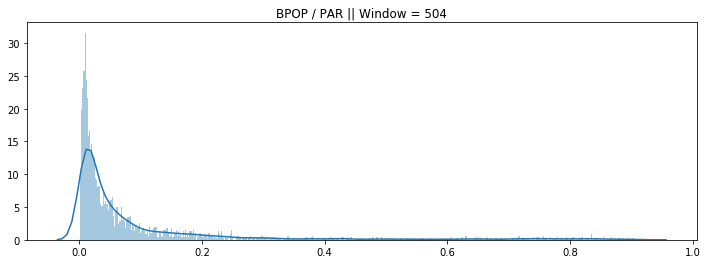

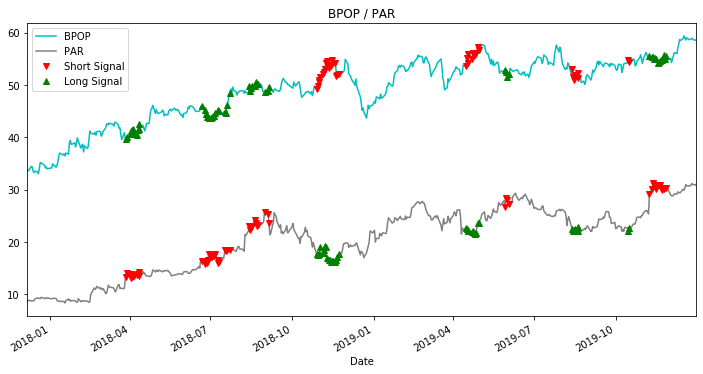

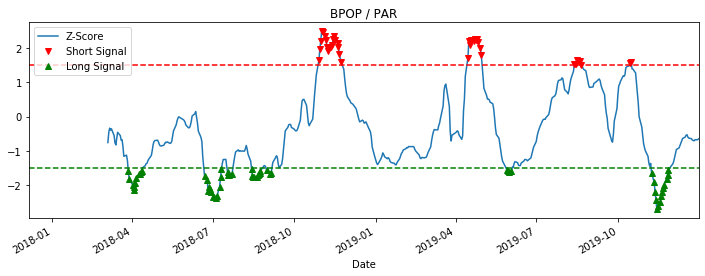

In [0]:
trigger = 1.5
w_t = 5
w_T = 60
pair_tickers = ['BPOP', 'PAR']
last_date = datetime(2020, 1, 1)
window = 252*3
numb_paths, w_p_value = 50, 252*2

pair_evaluation(pair_tickers, last_date, trigger, w_t, w_T, numb_paths ,window, w_p_value,'Y')

## Ejemplo Función Encontrar Pares

[['AAPL', 'DIA'], ['BA', 'MSFT'], ['DIA', 'MSFT'], ['RCL', 'TCBK'], ['VRSN', 'BA']]


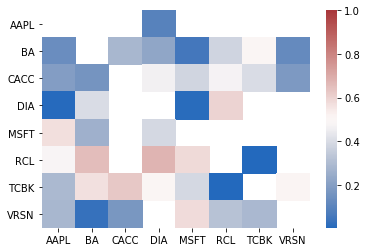

In [0]:
tckrs = ['VRSN','CACC','RCL','TCBK','AAPL','MSFT','BA','DIA']
tck_data = oget(tckrs,datetime(2019, 1, 1),datetime(2020, 1, 1))
all_clspx = tck_data[['Adj Close']].reset_index()
daily_px = all_clspx.pivot('Date', 'Ticker','Adj Close')

scores, pvalues, pairs = find_cointegrated_pairs(daily_px,252)
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
#print(pvalues)
print(pairs)
tckrs.sort()
sns.heatmap(pvalues, xticklabels=tckrs, yticklabels=tckrs, cmap='vlag', mask = (pvalues >= 0.7))
plt.show();

# Ejemplo Función de Backtesting

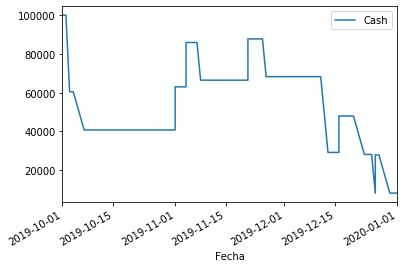

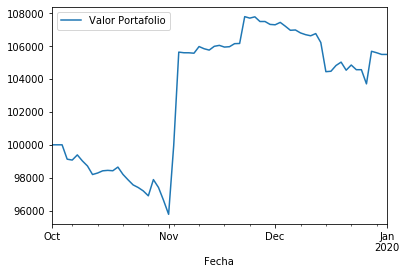

In [0]:
start = datetime(2019, 10, 1)  # datetime(2019, 8, 1)
end = datetime(2020, 1, 1)
tckrs = ['VRSN','CACC','RCL','TCBK','AAPL','MSFT','BA','DIA']
window_hist = 252
trigger = 1.96
lim_trigger = 2.5
stop_loss_trigger = 3.0
take_prof_trigger = 0.5
pos_size = .2
max_expo = 5
cash_0 = 100000

port_df1, cash_df1, open_ops1, closed_ops1 = bla(tckrs, start, end, window_hist, trigger, lim_trigger, stop_loss_trigger, take_prof_trigger, pos_size, max_expo, cash_0)
cash_df1.plot();
port_df1.plot();

In [0]:
open_ops1

,t_apertura,t_cierre,ID,TYPE,A,B,P_A_0,P_B_0,Q_A,Q_B,P_A_T,P_B_T,NOMINAL
0,2019-10-03,2019-11-01,1109709029,SHORT,AAPL,RCL,219.638,103.543,-61,61,254.45,110.5,22262
0,2019-10-03,2019-11-04,4159979762,SHORT,AAPL,TCBK,219.638,35.0226,-78,78,256.121,37.6677,22915.5
0,2019-10-07,2019-11-21,1918422055,SHORT,DIA,RCL,263.154,101.973,-54,54,276.744,117.964,21314.3
0,2019-12-12,2019-12-16,1342837017,LONG,BA,DIA,344.242,280.959,31,-31,325.066,282.075,18821.4
0,2019-11-08,2019-12-26,1894777868,LONG,BA,AAPL,348.924,259.524,32,-32,327.969,289.224,19750.2


In [0]:
closed_ops1

,t,ID,TYPE,A,B,P_A_0,P_B_0,P_0,mu_0,std_0,par,Q_A,Q_B,z_0
0,2019-11-26,794312248,LONG,CACC,AAPL,432.28,263.664,1.63951,2.24172,0.280274,CACC-AAPL,28,-28,-2.14866
0,2019-12-13,637908154,LONG,BA,MSFT,339.649,154.109,2.20395,2.63072,0.19947,BA-MSFT,40,-40,-2.13951
0,2019-12-23,577776447,SHORT,RCL,TCBK,133.4,41.02,3.25207,3.05215,0.0961529,RCL-TCBK,-114,114,2.07925
0,2019-12-26,1704382681,LONG,DIA,MSFT,285.925,158.238,1.80693,1.94044,0.0672281,DIA-MSFT,45,-45,-1.98583
0,2019-12-30,8083486993,SHORT,AAPL,MSFT,290.83,157.161,1.85052,1.59901,0.128027,AAPL-MSFT,-44,44,1.96452
